# Developing ngmix-free metacalibration with cookie-cutter

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from astropy.io import fits
import galsim
import fitsio
import time
import superbit_lensing.oba.metacal as mcal
from superbit_lensing import cookiecutter
from scipy.optimize import minimize

## Test mcal functions on COSMOS

In [3]:
boxsize=51
pixel_scale=.1

In [4]:
import superbit_lensing.oba.measure as meas
meas.generate_gal(7,565)

galsim.Transformation(galsim.Sersic(n=0.30000000000000004, scale_radius=0.6959368904137445, trunc=0.0, flux=4.535268860380321, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.5052460000759371, 0.211430305895889], [0.211430305895889, 0.6940412226297401]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=271.7192057897698, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

Text(0.5, 1.0, 'Pixelisation')

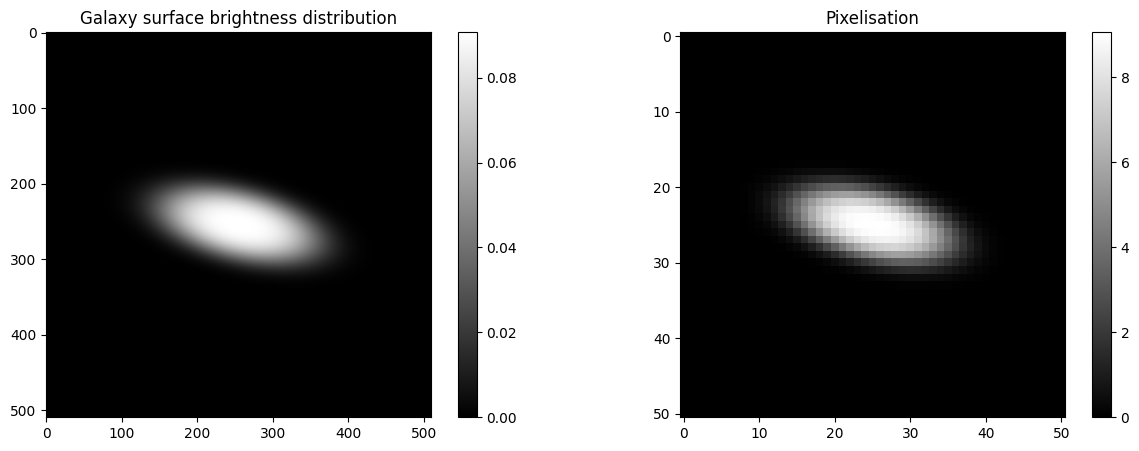

In [5]:
gal = meas.generate_gal(7,565)
figure(figsize(15,5))
subplot(121)
imshow(gal.drawImage(nx=510,ny=510,scale=0.01).array,cmap="gist_gray");colorbar()
title("Galaxy surface brightness distribution")
subplot(122)
imshow(gal.drawImage(nx=51,ny=51,scale=0.1).array,cmap="gist_gray");colorbar()
title("Pixelisation")

get psf

In [6]:
psf = fitsio.FITS("../superbit_lensing/oba/sims/sed_true_26892756.os.fits")

In [7]:
true_psf1 = meas.galsimator(psf[1].read(),pixel_scale=.1/5)
true_psf2 = meas.galsimator(psf[1].read(),pixel_scale=.1005/5) #.5pc defocused?

Observed psfs have a bit of noise

Text(0.5, 1.0, 'example of observed psf')

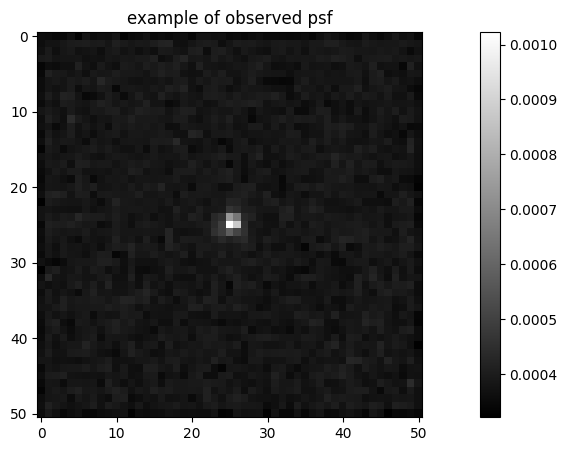

In [8]:
psf_nois = meas.make_noise(boxsize=51,sky_level=0.1,noise_level=0.005)
imshow((true_psf1 + meas.galsimator(psf_nois,pixel_scale=.1)).withFlux(1).drawImage(nx=51,ny=51,scale=.1).array,cmap="gist_gray");colorbar()
title("example of observed psf")

In [9]:
obs_psf1 = (true_psf1 + meas.galsimator(psf_nois,pixel_scale=.1)).withFlux(1)
obs_psf2 = (true_psf2 + meas.galsimator(psf_nois.T,pixel_scale=.1)).withFlux(1)

Text(0.5, 1.0, 'Exposure 2')

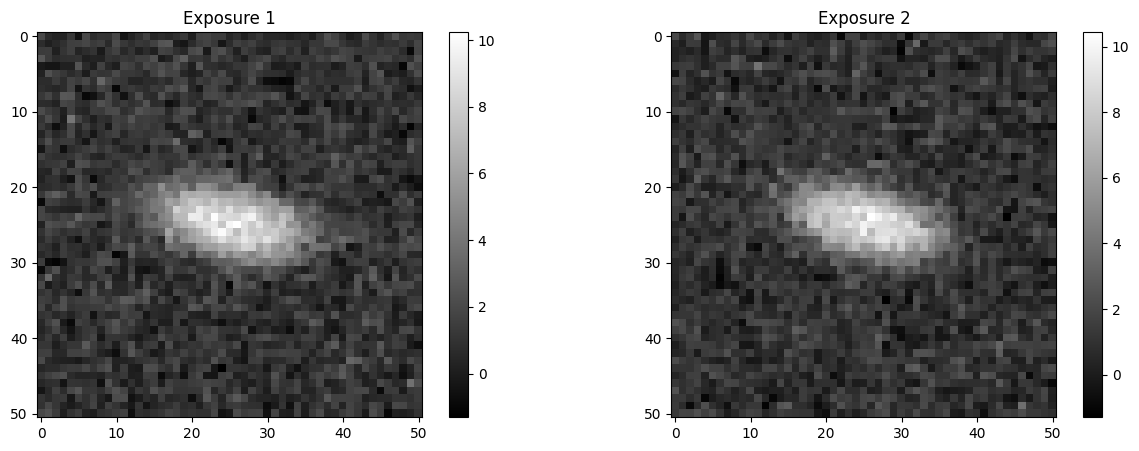

In [10]:
nois = meas.make_noise(boxsize=51,sky_level=1.,noise_level=1.)
psfs = array([true_psf1,true_psf2])
obs1 = galsim.Convolve([gal,true_psf1]) + meas.galsimator(nois,pixel_scale=.1)
obs2 = galsim.Convolve([gal,true_psf2]) + meas.galsimator(nois.T,pixel_scale=.1)
obs_ims = array([obs1.drawImage(nx=51,ny=51,scale=.1).array,obs2.drawImage(nx=51,ny=51,scale=.1).array])

figure(figsize=(15,5))
subplot(121)
imshow(obs_ims[0],cmap="gist_gray");colorbar()
title("Exposure 1")
subplot(122)
imshow(obs_ims[1],cmap="gist_gray");colorbar()
title("Exposure 2")

create a loss function for optimization

In [11]:
model = meas.gaussian_model
loss=meas.create_loss(model=model,images=obs_ims,sky_levels=[1.,1.],psf_objs=psfs,boxsize=51,pixel_scale=.1)

In [12]:
gal_flu = sum(obs_ims[0]) - 1.*boxsize**2

In [13]:
result=minimize(loss,x0=array([gal_flu,1.,0.,0.]),bounds=[(gal_flu*0.5,gal_flu*1.5),(.1,10.),(-.7,.7),(-.7,.7)],method='Nelder-Mead')
print(*result.x)

1310.9037089115996 0.5047549903324013 0.38016804824308037 0.1849773264160196


In [14]:
fitted=model(*result.x,[1.,1.],psfs,51,.1)

Text(0.5, 1.0, 'Residuals 2')

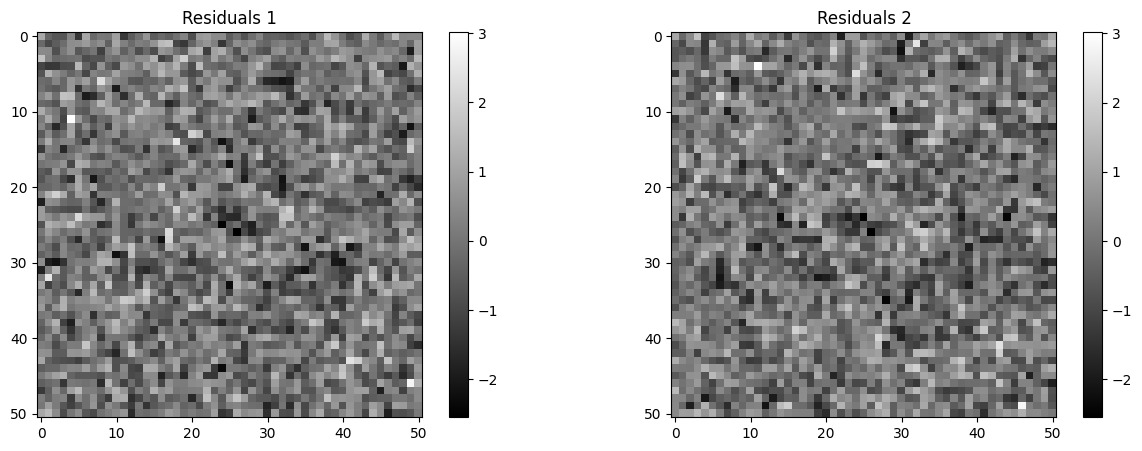

In [15]:
figure(figsize=(15,5))
subplot(121)
imshow(obs_ims[0]-fitted[0],cmap="gist_gray");colorbar()
title("Residuals 1")
subplot(122)
imshow(obs_ims[1]-fitted[1],cmap="gist_gray");colorbar()
title("Residuals 2")

## Metacalibration

In [16]:
reconv_psf = galsim.Gaussian(fwhm=.7)

In [17]:
obsdict=mcal.get_all_metacal(gals=[meas.galsimator(obs_ims[0]),meas.galsimator(obs_ims[1])] ,
                     psfs=psfs,
                     reconv_psfs=[reconv_psf,reconv_psf],fixnoise=False)

(-0.5, 50.5, 50.5, -0.5)

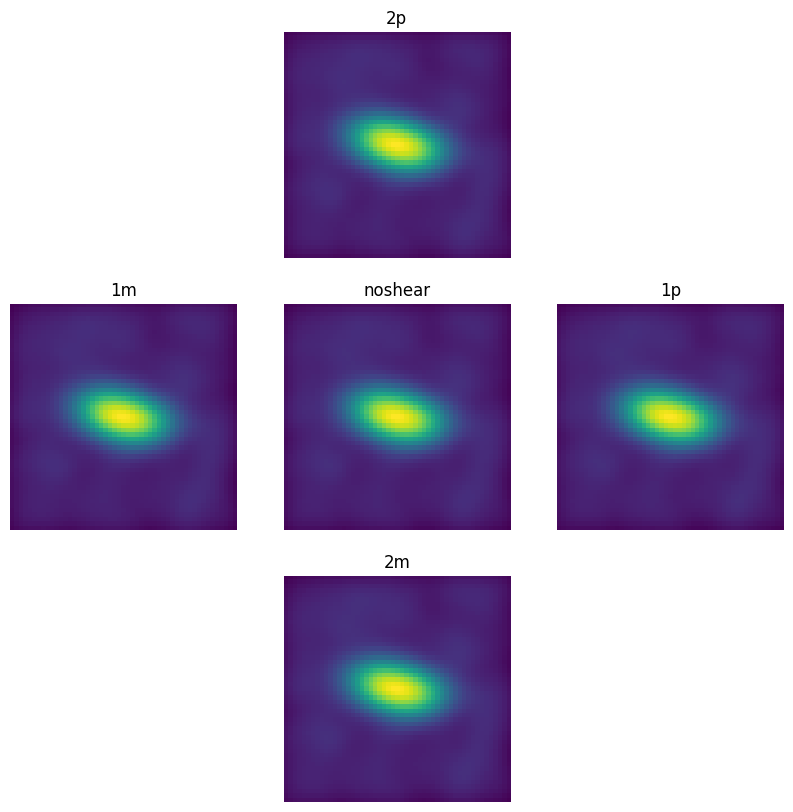

In [18]:
exp=0
figure(figsize=(10,10))
subplot(332)
imshow(obsdict['2p']['obs'][exp].drawImage(nx=51,ny=51,scale=.1).array)
title('2p')
axis('off')
subplot(334)
imshow(obsdict['1m']['obs'][exp].drawImage(nx=51,ny=51,scale=.1).array)
title('1m')
axis('off')
subplot(335)
imshow(obsdict['noshear']['obs'][exp].drawImage(nx=51,ny=51,scale=.1).array)
title('noshear')
axis('off')
subplot(336)
imshow(obsdict['1p']['obs'][exp].drawImage(nx=51,ny=51,scale=.1).array)
title('1p')
axis('off')
subplot(338)
imshow(obsdict['2m']['obs'][exp].drawImage(nx=51,ny=51,scale=.1).array)
title('2m')
axis('off')


In [19]:
from scipy.optimize import dual_annealing

In [20]:
def get_ellipticities(obss,psfs,sky_levels):
  gal_flu = (np.sum(obs_ims,axis=(1,2)) - sky_levels*boxsize**2).mean()
  loss=meas.create_loss(model=model,images=obss,sky_levels=[1.,1.],psf_objs=psfs,boxsize=51,pixel_scale=.1)
  result=dual_annealing(loss,x0=array([gal_flu,1.,0.0,0.]),bounds=[(gal_flu*0.5,gal_flu*1.5),(.1,10.),(-.7,.7),(-.7,.7)])#,method='Nelder-Mead')
  print(result)
  return result.x[-2:]

In [37]:
from superbit_lensing.oba.metacal import measure_ellipticities

In [21]:
def measure_ellipticities(obsdict,method):
    resdict = {}
    for key in obsdict.keys():
        resdict[key] =  {'g' : method(obsdict[key])}
    return resdict

In [22]:
def method(obstype,sky_levels=array([1.,1.])):
  obss=np.array([obs.drawImage(nx=boxsize,ny=boxsize,scale=pixel_scale).array for obs in obstype['obs']])
  psfs=obstype['psf']
  result=get_ellipticities(obss,psfs,sky_levels)
  return result
  

In [23]:
resdict=measure_ellipticities(obsdict=obsdict,method=method)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 840.1436
       x: [ 1.307e+03  5.951e-01  2.893e-01  1.561e-01]
     nit: 1000
    nfev: 10116
    njev: 423
    nhev: 0
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 841.37994
       x: [ 1.308e+03  5.963e-01  2.962e-01  1.551e-01]
     nit: 1000
    nfev: 10866
    njev: 573
    nhev: 0
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 842.5772
       x: [ 1.305e+03  5.940e-01  2.832e-01  1.574e-01]
     nit: 1000
    nfev: 10346
    njev: 469
    nhev: 0
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 842.4225
       x: [ 1.307e+03  5.956e-01  2.879e-01  1.641e-01]
     nit: 1000
    nfev: 10261
    njev: 452
    nhev: 0
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 839.1826
       x: [ 1.306e+03  5.948e-01  2.910e-01  1.488e-01]
     nit: 1

In [24]:
e, R = mcal.get_metacal_response(resdict)

In [25]:
e

{'noshear': array([0.28931747, 0.15609003]),
 '1p': array([0.29619726, 0.1550795 ]),
 '1m': array([0.28316849, 0.15744707]),
 '2p': array([0.28794054, 0.16409882]),
 '2m': array([0.2909625, 0.1487933])}

In [26]:
np.linalg.inv(R) @ e['noshear']

array([0.50971791, 0.28281261])

In [36]:
Table.read("euclid/test_obj_wcs/Abell2813/det/cat/Abell2813_coadd_det_cat.fits").colnames

['ALPHAWIN_J2000',
 'DELTAWIN_J2000',
 'X_IMAGE',
 'Y_IMAGE',
 'NUMBER',
 'KRON_RADIUS',
 'BACKGROUND',
 'THRESHOLD',
 'FLAGS',
 'CLASS_STAR',
 'FLUX_RADIUS',
 'FLUX_APER',
 'ELLIPTICITY',
 'SNR_WIN']

## Make bridge between cookiecutter and mcal

lets take a look into cookiecutter images

In [27]:
cookie=cookiecutter.CookieCutter(cookiecutter_file="euclid/euclid_test/Abell2813/vis/out/Abell2813_vis_cutouts.fits")
cookie.initialize()
cctable=Table.read("euclid/euclid_test/Abell2813/vis/out/Abell2813_vis_cutouts.fits")

In [38]:
cctable

object_id,xcen,ycen,start_index,end_index,sky_bkg,sky_var,img_ext
uint32,float64,float64,uint32,uint32,float64,float64,uint16
1,17.48833870709268,2576.1238526102225,0,256,-1.0,-1.0,0
2,7.977188865760127,1907.8452100795862,256,1280,-1.0,-1.0,0
95,4131.297578312035,2803.158219176083,1280,1536,-1.0,-1.0,0
96,4145.382527707323,3655.5375424820318,1536,2560,-1.0,-1.0,0
97,4128.359477296903,3548.7969988811565,2560,2816,-1.0,-1.0,0
98,4125.178787225318,2103.6539405567673,2816,3072,-1.0,-1.0,0
99,4125.253537739998,2014.0485940141562,3072,3328,-1.0,-1.0,0
100,4123.998560641996,490.61621405776805,3328,3584,-1.0,-1.0,0
101,4119.507970232278,3850.518609009047,3584,3840,-1.0,-1.0,0


In [33]:
cookie.meta

array([(   1,  1.74883387e+01, 2576.12385261,      0,    256, -1., -1., 0),
       (   2,  7.97718887e+00, 1907.84521008,    256,   1280, -1., -1., 0),
       (  95,  4.13129758e+03, 2803.15821918,   1280,   1536, -1., -1., 0),
       ...,
       (1245, -2.38183962e+00, 3383.07829573, 455168, 455424, -1., -1., 3),
       (1246, -2.33488982e+00, 3197.33890656, 455424, 455680, -1., -1., 3),
       (1247, -5.47938993e+00,   82.25646434, 455680, 455936, -1., -1., 3)],
      dtype=[('object_id', '>u4'), ('xcen', '>f8'), ('ycen', '>f8'), ('start_index', '>u4'), ('end_index', '>u4'), ('sky_bkg', '>f8'), ('sky_var', '>f8'), ('img_ext', '>u2')])

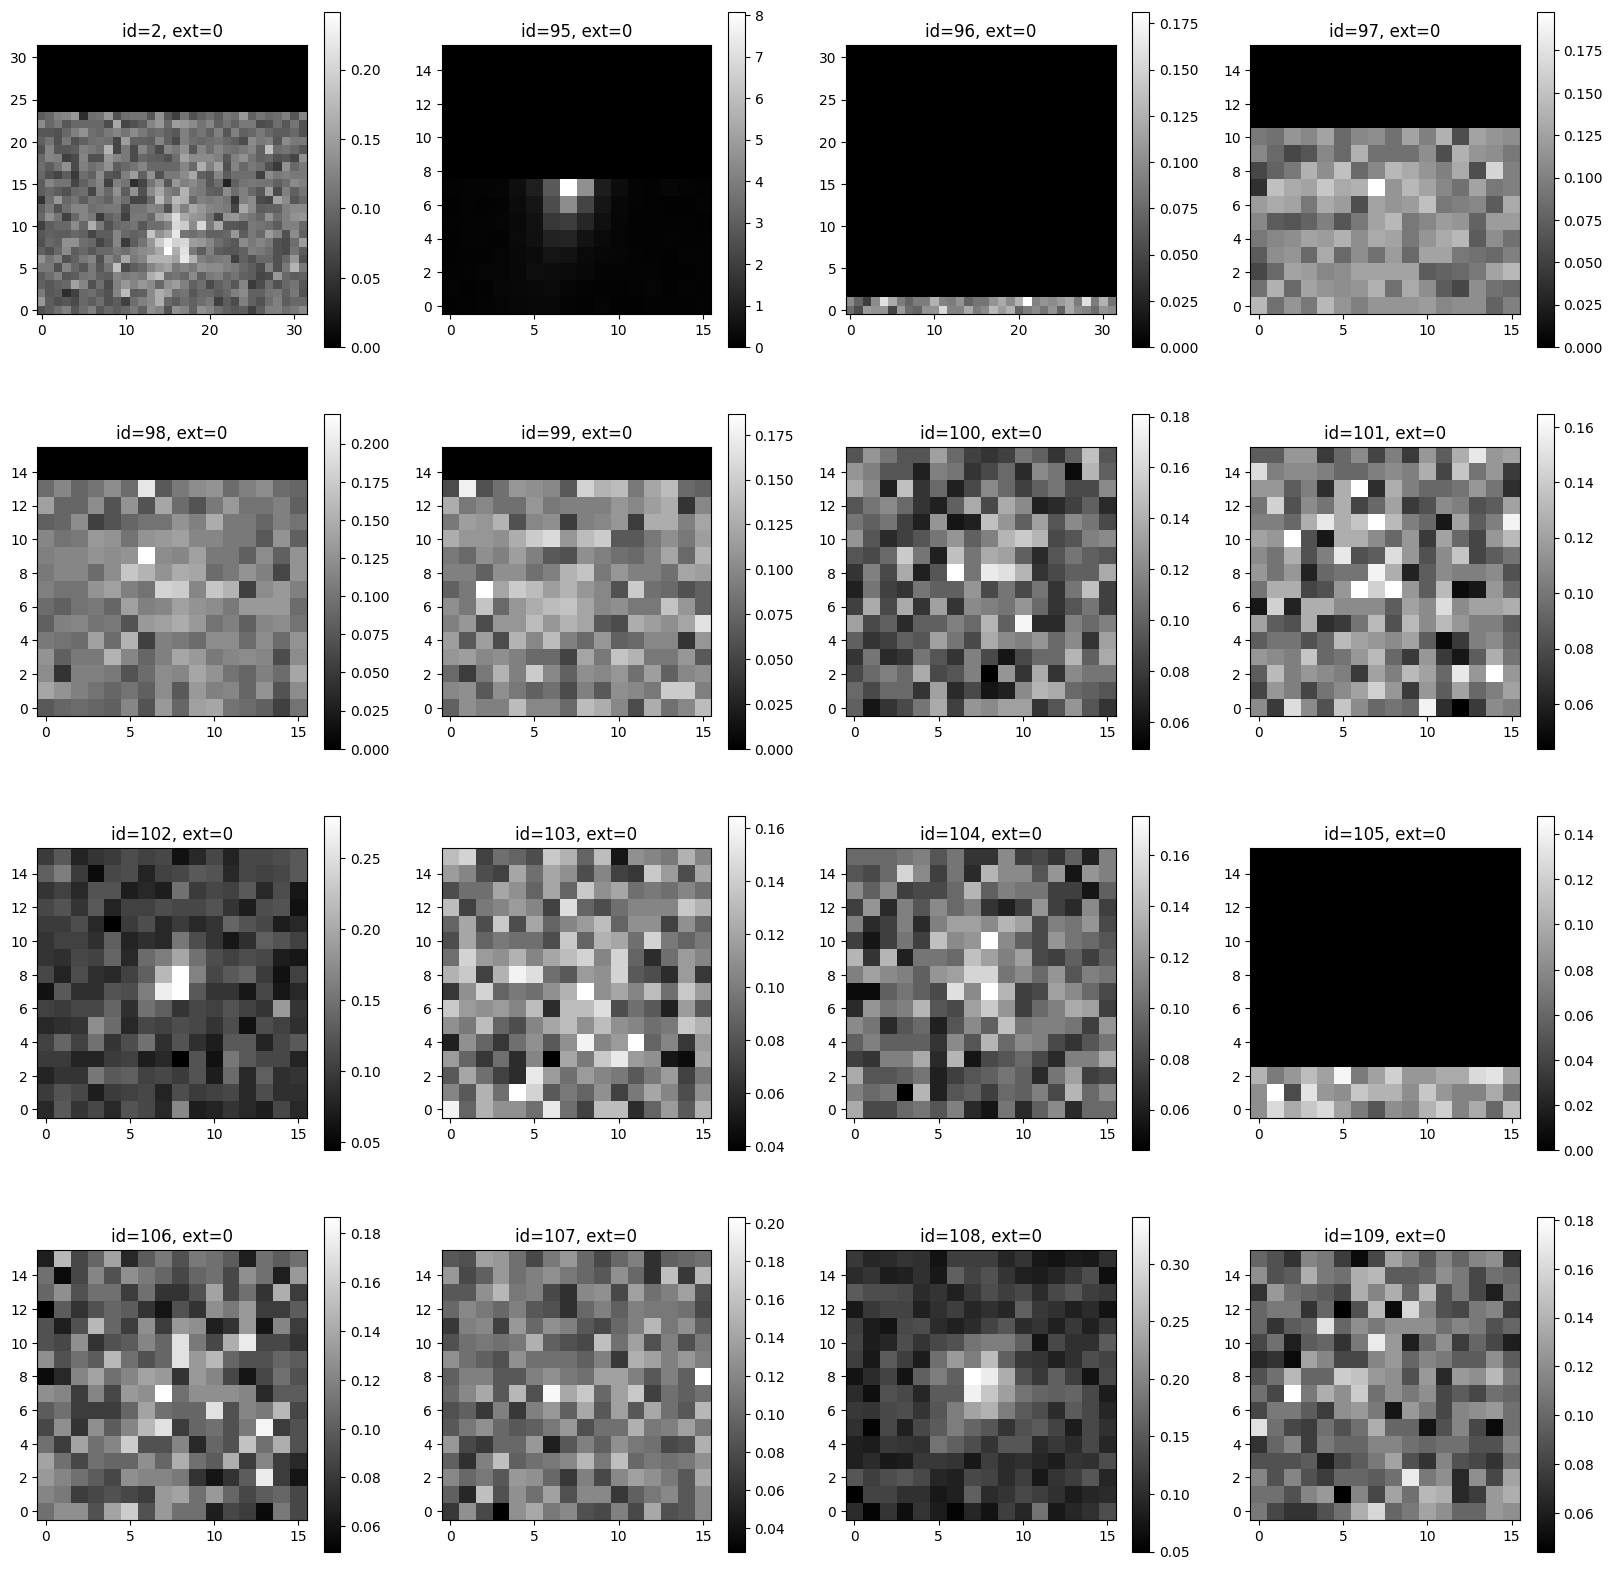

In [28]:
figure(figsize=(20,20))
pos = 0
while pos <  16:
  pos+=1
  choice = pos#np.random.randint(0,len(cctable))
  obj_id = cctable[choice]['object_id']
  ext_no = cctable[choice]['img_ext']
  cut = cookie.get_cutout(obj_id,extnumber=ext_no)
  subplot(4,4,pos)
  imshow(cut,origin='lower',cmap='gist_gray');colorbar()
  title(f"id={obj_id}, ext={ext_no}")
  
savefig(f"cookies_{time.time()}.png")

## Test mcal functions on cookiecutter results

## Get some results